In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
import seaborn as sb

# local imports
from train.dataloader import create_datasets_sim
from train.model import vgg13bn, vggSmall
from train.train import train_model

# plots setting
sb.set(font_scale=1.25)
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Predict steady state
Given $m$ observations from the quantum trajectory samples can we predict if the particle is in a steady state? We will try with different values of $m$. First we manipulate the data to get the label of steady state, with will be binery.

In [2]:
# psysical model parameters
N = 100 # NOTE: must be fixed for the CNN
g = 0.25
a0 = 1/np.sqrt(2)

# data
N_data = 1000

# ML parameters
epochs = 10 
lr = 1e-4
batch_size = 128
folds = 10


N_sim and N are equal, changing N_sim to N+1


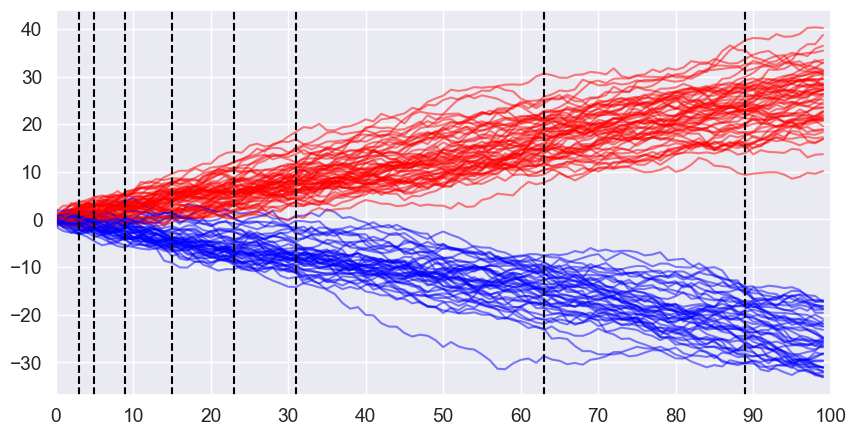

The different m values are: [90, 64, 32, 24, 16, 10, 6, 4]


In [3]:
test_dataset  =  create_datasets_sim(100,1, N=N, g=g, a0=a0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


M = [90,64, 32, 24, 16, 10, 6, 4]
# plot some examples from the dataset
Xtest, ytest = test_dataset.tensors
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(Xtest.shape[0]):
    X = Xtest[i].numpy()
    label = ytest[i].item()
    if label == 0:
        ax.plot(range(X.shape[-1]), np.cumsum(X.squeeze(0)), color='blue', alpha=0.5)
    else:
        ax.plot(range(X.shape[-1]), np.cumsum(X.squeeze(0)), color='red', alpha=0.5)

# vertical lines for M
for m in M:
    ax.axvline(m-1, color='black', linestyle='--')

ax.set_xlim([0, N])
ax.set_xticks(range(0, N+1, 10))
plt.show()
print(f"The different m values are: {M}")




In [4]:
# train and val dataset
train_dataset, val_dataset =  create_datasets_sim(N_data,0.8, N=N, g=g, a0=a0)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

models = []
stats = []

loss_fn = torch.nn.CrossEntropyLoss()

for m in tqdm(M):
    # model
    model = model = vggSmall(num_classes=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # train
    model, stat = train_model(model, train_loader, val_loader, m, epochs, loss_fn, optimizer, device , verbose=False)

    # save
    models.append(model)
    stats.append(stat)

100%|██████████| 8/8 [00:36<00:00,  4.56s/it]


plot loss curves

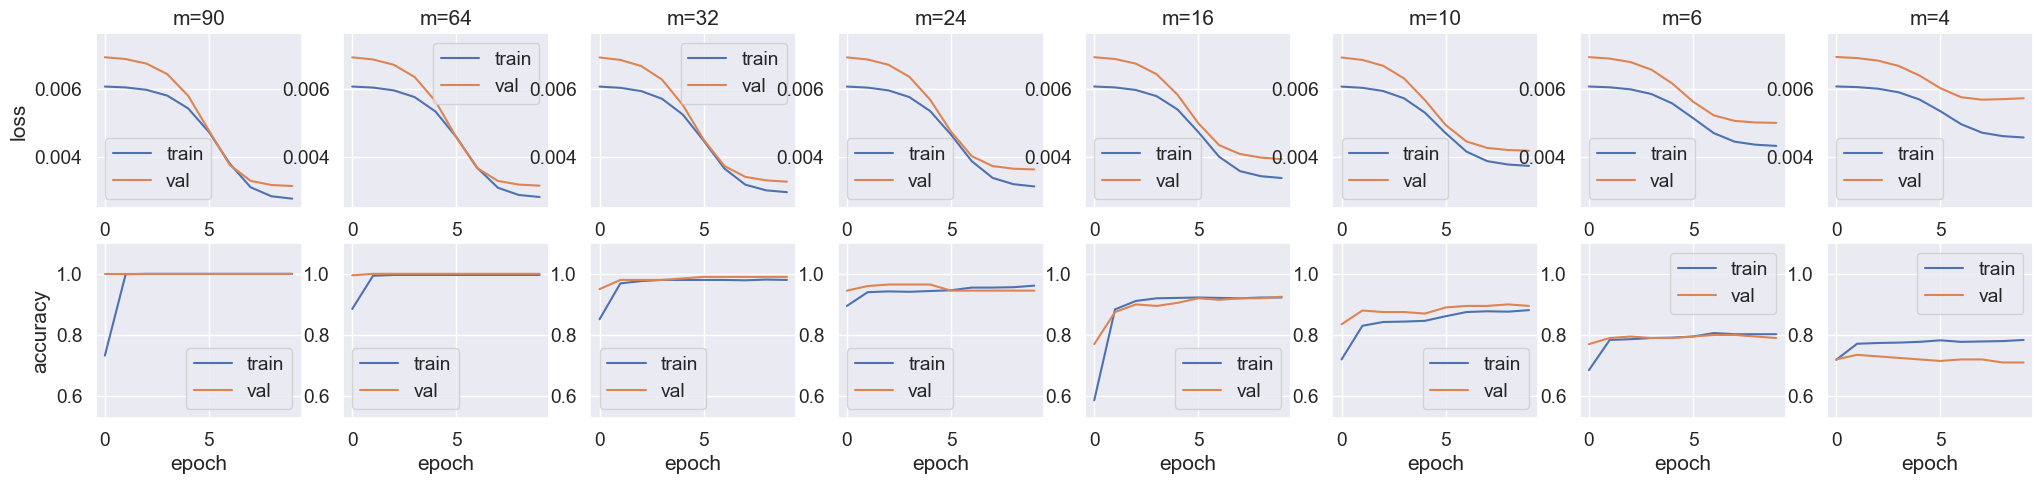

In [5]:
# overall min and max acc and losses on both train and val
min_loss = min([min(stat['train_loss']+stat['val_loss']) for stat in stats])
max_loss = max([max(stat['train_loss']+stat['val_loss']) for stat in stats])
min_acc = min([min(stat['train_acc']+stat['val_acc']) for stat in stats])
max_acc = max([max(stat['train_acc']+stat['val_acc']) for stat in stats])


fig, axes = plt.subplots(2, len(M), figsize=(25,5))

for i, stat in enumerate(stats):
    
    # set title
    axes[0,i].set_title(f"m={M[i]}")
    axes[0,i].plot(stat['train_loss'], label='train')
    axes[0,i].plot(stat['val_loss'], label='val')
    axes[0,i].legend()
    #axes[0,i].set_xlabel('epoch')
    if i == 0:
        axes[0,i].set_ylabel('loss')
    axes[0,i].set_ylim([min_loss*0.9, max_loss*1.1])
    

    axes[1,i].plot(stat['train_acc'], label='train')
    axes[1,i].plot(stat['val_acc'], label='val')
    axes[1,i].set_xlabel('epoch')
    if i==0:
        axes[1,i].set_ylabel('accuracy')
    axes[1,i].legend()
    axes[1,i].set_ylim([min_acc*0.9, max_acc*1.1])
plt.show()

## Performance on the test set
how is the performance on the test set?

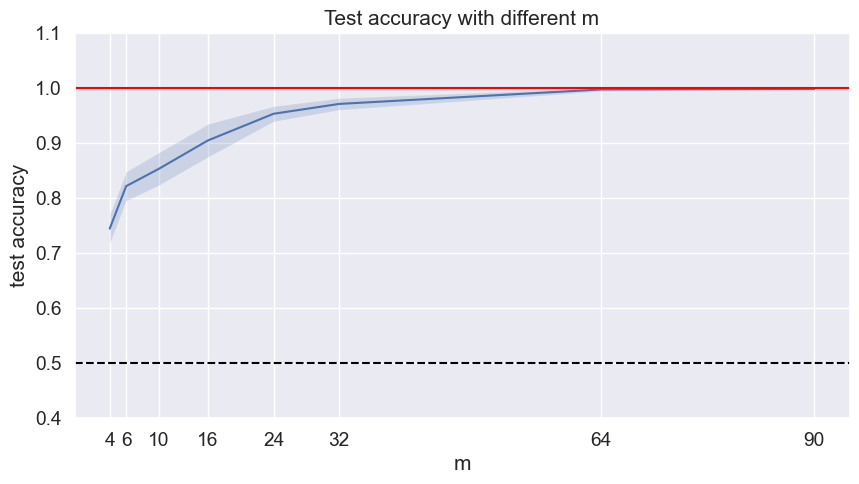

In [7]:

test_acc = np.zeros((len(M), folds))

for i, model in enumerate(models):
    for j in range(folds):
        acc = 0
        test_dataset  =  create_datasets_sim(200,1, N=N, g=g, a0=a0)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
        for X, y in test_loader:
            X = X[:,:,:M[i]]
            yhat = model(X)
            acc += (yhat.argmax(1) == y).float().mean().item()

        test_acc[i,j] = acc/len(test_loader)

mean_test_acc = test_acc.mean(axis=1)

plt.figure(figsize=(10,5))
plt.title('Test accuracy with different m')
plt.plot(M, mean_test_acc)
plt.fill_between(M, mean_test_acc - test_acc.std(axis=1), mean_test_acc + test_acc.std(axis=1), alpha=0.2)
plt.xlabel('m') 
plt.ylabel('test accuracy')
plt.ylim(0.4,1.1)
plt.xticks(M)
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(1, color='red')
plt.show()